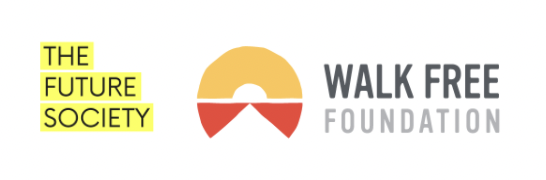

#*Project AIMS (AI against Modern Slavery)*
---




 
##💻 Note: You can run this notebook locally or on Google Colab following this [link](https://drive.google.com/file/d/13uuX8xducNRhWVyF3FOxF-uE8bstIbaZ/view?usp=sharing).

# Modern Slavery Policy
##Does the company’s statement detail specific organisational policies or actions to combat slavery in their direct (tier 1) and/or in-direct (beyond tier 1) supply chain?
 
This task aims to build a system to identify whether the company’s statement detail clear, organisational modern slavery policies that apply to their direct and/or beyond tier 1 supply chain. These policies must be explicit and go beyond vague statements of intended actions. Often these policies can be found at the beginning of a statement. Direct supply chains can also be referred to as tier 1 supply chains and consequently beyond tier 1 includes all players of the supply chain that are not directly tied to the company. This metric refers to organisational policies that are clear and explicitly tackle and prevent modern slavery.
 
Direct supply chains can also be referred to as tier 1 supply chains and consequently beyond tier 1 includes all players of the supply chain that are not directly tied to the company.
 
Policies include:
- requiring all suppliers and contractors to comply with local and international laws (including the UN Guiding Principles, ILO standards, or International Conventions), and company’s policies
- prohibiting contractors or suppliers from using forced labour, involuntary labour, debt bondage, or human trafficking
- prohibiting contractors or suppliers from using child labour
including clauses on forced labour in Codes of Conduct or Supplier Codes
- requiring contracts to include clauses on forced labour in supply chains
- requiring all suppliers and contractors to respect labour rights more generally, such as paying living wages or allowing freedom of association
- requiring all suppliers and contractors to ensure employees are not charged fees as part of their recruitment
- requiring all suppliers and contractors to provide additional protection for migrant workers
- requiring suppliers to produce their statement on modern slavery and forced labour
 
For more information about this metric, please refer to  [WikiRate’s Research on MSA policy (revised) metric](https://wikirate.org/Walk_Free_Foundation+MSA_policy_revised)or [ Home Office Guidance, pp. 28-30](https://wikirate.org/Walk_Free_Foundation+MSA_policy_revised). 
 
### Labelled dataset
When building the ground truth data, the annotators selected the labels of the policies which are adhered to by 'direct' or 'Tier 1' suppliers or by 'Tier 2' or 'beyond Tier 1' or 'in-direct suppliers. If it is not specifically mentioned which supply chain tiers these policies apply to, it was assumed that they cover direct suppliers only. If any of those labels were found, the statement was labelled with ‘Yes/1’ for a task.
 
If no such policy was found in the statement, then the label given was 'No'. If the business indicates it is developing a modern slavery supply chain policy or planning to implement one in the future, the label given to the statement was 'In Development'. The statements labelled ‘No’ or ‘In Development’ were given the generic label ‘No/0’ for this task.
 



In [ ]:
#!python3 -m spacy download en_core_web_sm
#!pip install unidecode
#!pip install snorkel
#!pip install contractions

## Setup

 
### 🗄️ You can access the data used in this notebook [here](https://drive.google.com/file/d/1gr9PbPTaYLnhVKJ6eraJboPmvLZ_E14J/view?usp=sharing). We recommend you re-run this research with an updated version of this data which can be downloaded following these [instructions](https://github.com/the-future-society/Project-AIMS-AI-against-Modern-Slavery/tree/main/%F0%9F%97%84%EF%B8%8F%20Data%20and%20text%20extraction/WikiRate).



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd /content/drive/MyDrive/ProjectAIMS

/content/drive/.shortcut-targets-by-id/11tRyVLvElSSvedZDsiP76NndaI3wNyFb/Project AIMS


In [ ]:
import pandas as pd
import re
from utils import sentencizer, evaluation_rb
from utils.preprocessing import *

#metric that we need to label
metric = 'Walk Free Foundation+MSA policy (revised)'

data = load_dataset(metric, 'labeled-dataset.csv')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Number of available statements for Walk Free Foundation+MSA policy (revised) -> 1,308



##Convert non-binary labels to binary labels

In [ ]:
for idx, row in data.iterrows():

    value = row[metric].lower()
    splitted_value = value.split(',')

    if "no" not in  splitted_value and  "in development" not in splitted_value:
        data.loc[idx,  metric] = 1
    if 'in development' in value and len(splitted_value)==1:
        data.loc[idx, metric] = 0
    if 'in development' in value and len(splitted_value)>1:
        data.loc[idx, metric] = 1
    if "no" in splitted_value or value == 'in development':
        data.loc[idx, metric] = 0

print(data[metric].value_counts())


1    1125
0     183
Name: Walk Free Foundation+MSA policy (revised), dtype: int64


In [ ]:
import sys
import spacy
import string
import snorkel
from sklearn.metrics import classification_report
from snorkel.labeling import labeling_function
from snorkel.labeling import PandasLFApplier
from snorkel.labeling.model import LabelModel
from snorkel.labeling.model import MajorityLabelVoter


from snorkel.preprocess import preprocessor

#possible labels for the statements
ABSTAIN = -1
NO = 0
YES = 1

In [ ]:
data['TEXT'][12]

'Primark Stores Ltd. Modern Slavery Statement 2016\nOur commitment to fighting modern slavery\nPrimark is a major retail group employing over 65,000 people. We operate stores in the UK, Republic of Ireland, mainland Europe and the USA. Our business directly contributes to the employment of around 730,000 workers across four continents and our annual revenue for our financial year ending 12 September 2015 was £5,347m. Buying and Merchandising teams in Dublin (Republic of Ireland) and Reading (UK) source and buy fashion items that best reflect each season’s key fashion trends. Primark’s range includes womenswear, lingerie, childrenswear, menswear, footwear, accessories, hosiery and homeware.\nWe believe that business can be a force for good if it acts responsibly towards those within its supply chain. As such, ensuring that workers’ rights are respected, and that we are able to affect positive change in line with the UN Guiding Principles on Business and Human Rights, our Code of Conduct

## Using regex and keywords classify each statement as either positive or negative

Before the Snorkel pipeline, duplicates and N/A values were removed from the dataset. Then the first step is to use the first component of a Snorkel pipeline which includes implementing labelling functions. Labelling functions are designed to be weak heuristic functions that predict a label given unlabelled data. The labelling functions applied were multiple keyword searches by using regular expression matching within the text. This method tries to identify organisational modern slavery policies that apply to their direct and/or beyond tier 1 supply chain. The output of the system is a prediction about whether a sentence could be classified as a modern slavery policy or not.
 
For a start, all the sentences containing the list of specific keywords identified in the Semantic workshop related to policy identification were extracted, The list of keywords are 'policy', 'polic(y|ies)', 'code of conduct', 'supplier code','principles'\, 'supplier(s) produce(s|e), (\stheir),(\sown), statement',\, 'supplier(s), respect(s), labo(u)r right(s)','employer pays principle',\ 'protect(s|ed) migrant workers',\ 'ilo',  'ungp', 'un guiding principles on business and human rights','recruitment fee(s)', 'collective bargaining''freedom of association','international labor organisation','contract(s) include(d) clause(s)' .



In [ ]:
policy_keywords = ['policy', 'polic(y|ies)', 'code of conduct', 'supplier code','principles'\
                   'supplier(s?) produce(s|e)?(\stheir)?(\sown)? statement',\
                   'supplier(s)? respect(s)? labo(u?)r right(s)?','employer pays principle',\
                   'protect(s|ed)? migrant workers',\
                    'ilo',  'ungp', 'un guiding principles on business and human rights',
                  'recruitment fee(s?)', 'collective bargaining''freedom of association','international labor organisation',
                   'contract(s?) include(d?) clause(s?)']

policy_keywords_re = re.compile( '|'.join(policy_keywords))
act = ['modern slavery act','msa','modern slavery']                      

policy = ['policy', 'policies']

In [ ]:
@labeling_function()
def vocabulary_keywords(x):
    text = str(x.TEXT).lower()
    return YES if re.search(policy_keywords_re, text)!= None else NO

In [ ]:
lfs = [vocabulary_keywords]

applier = PandasLFApplier(lfs=lfs)
L_test = applier.apply(df=data)
L_train = applier.apply(df = data)


coverage_policy = (L_test== YES).mean(axis=0)

100%|██████████| 1308/1308 [00:00<00:00, 7072.92it/s]


In [ ]:
print("Coverage for Policy metric is",coverage_policy[0])

Coverage for Policy metric is 0.9327217125382263


In [ ]:
%%time

majority_model = MajorityLabelVoter()
final_labels = majority_model.predict(L=L_test)

CPU times: user 19.8 ms, sys: 0 ns, total: 19.8 ms
Wall time: 22.9 ms


##Results
The method yields 84% accuracy. The full results are depicted in the following table. 

Evaluation of the rule-based model


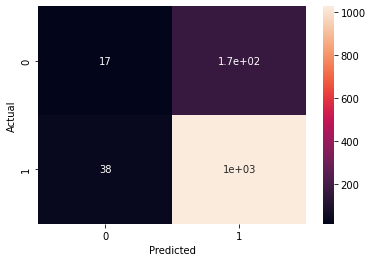

Confusion Matrix:
 [[  17  166]
 [  38 1026]]
Accuracy Score: 0.8364073777064955
Precision Score: 0.7797827904726071
Recall Score: 0.8364073777064955
F1 Score: 0.7970570097717805


In [ ]:
y_test = data[metric]
y_test = y_test.astype('int')

y_hat = [v if v == 1 else 0 for v in final_labels]
evaluation_rb.main(y_test,y_hat)

In [ ]:
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.31      0.09      0.14       183
           1       0.86      0.96      0.91      1064

    accuracy                           0.84      1247
   macro avg       0.58      0.53      0.53      1247
weighted avg       0.78      0.84      0.80      1247

